# Predição de Casos de COVID com AutoML

In [1]:
from PIL import Image
pil_im = Image.open('../input/logocanal/LOGO PNG.png')
pil_im

FileNotFoundError: [Errno 2] No such file or directory: '../input/logocanal/LOGO PNG.png'

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Lendo os dados

In [3]:
import pandas as pd
from statistics import mean 
df=pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv')

# Definindo uma função para ler os Dados de X e Y

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from numpy import array


def country_data(country):

    tscv = TimeSeriesSplit()

    df_country=df[df['Country/Region']==country]
    df_country_grouped=df_country.groupby(['Date']).sum()


    scores=pd.DataFrame(columns=['Model','R2'])

    X_train_list=[]
    X_test_list=[]
    y_train_list=[]
    y_test_list=[]


    series=df_country_grouped['Active']
    # split a univariate sequence into samples
    def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)

    # choose a number of time steps
    n_steps = 25
    # split into samples
    X, y = split_sequence(series, n_steps)

    from sklearn.preprocessing import MinMaxScaler

    X=MinMaxScaler().fit_transform(X,y)
    
    return X,y


    

# Separando os dados de X e Y

In [5]:
X,y=country_data('Italy')

# Instalando as ferramentas necessárias

In [6]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [7]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


## Iniciando Servidor de H2O

In [8]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjs0qtkyk
  JVM stdout: /tmp/tmpjs0qtkyk/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjs0qtkyk/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,3 months and 24 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_f93xg4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


## Treinando e escolhendo melhores Modelos

In [9]:
X=pd.DataFrame(X)
X['target']=y
data = h2o.H2OFrame(X)

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

y_ = 'target'
x = list(data.columns)

x.remove(y_)  
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=5, seed=1)
aml.train(x=x, y=y_, training_frame=train)


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


# Listando melhores modelos

In [10]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201114_183530,5.05245e+06,2247.77,5.05245e+06,1600.27,0.899751
StackedEnsemble_BestOfFamily_AutoML_20201114_183530,5.31242e+06,2304.87,5.31242e+06,1652.71,0.843406
XGBoost_3_AutoML_20201114_183530,5.65635e+06,2378.31,5.65635e+06,1643.15,nan
DRF_1_AutoML_20201114_183530,5.72225e+06,2392.12,5.72225e+06,1538.22,0.547414
XGBoost_2_AutoML_20201114_183530,7.22478e+06,2687.9,7.22478e+06,1911.31,1.08521
XGBoost_1_AutoML_20201114_183530,8.44021e+06,2905.2,8.44021e+06,1925.18,0.66
GLM_1_AutoML_20201114_183530,1.25457e+09,35419.9,1.25457e+09,31304,2.10595


# Apresentando o score e o resultado alcançado

stackedensemble prediction progress: |████████████████████████████████████| 100%
[922.8345463526517, 4499.633340380151, 57107.19394183403, 94293.70944891256, 98372.63127682092, 107693.54817772463, 107676.76090711322, 105577.56497274482, 102946.55257182283, 82693.21615749659, 82333.1184272549, 62583.648382354084, 39213.77598401099, 35337.41378213163, 33934.789953028485, 27433.18466309041, 19263.41086388834, 19142.7444638245, 15964.281459555501, 12811.046940242031, 12829.747228941662]
[311, 5061, 62013, 94067, 100269, 108257, 108237, 105205, 104657, 81266, 78457, 60960, 39297, 35262, 31710, 26274, 18303, 17638, 15255, 12301, 12565]


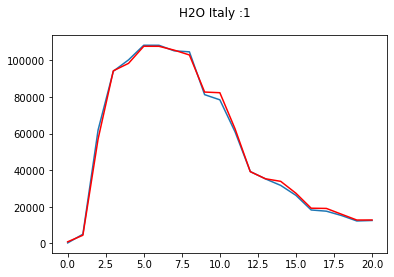

R2 Score: 0.9979911320630347
MSE Score: 2958250.0270406255
MAE Score: 1229.8864328624475


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
#X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1],1))
#     # fit model

predictions=aml.predict(test)
count=1



ypred=list(predictions.as_data_frame()['predict'])
print(ypred)
y_test=list(test.as_data_frame()['target'])
print(y_test)
error = mean_squared_error(y_test, ypred)

title='H2O Italy :'+str(1)
count+=1
fig = plt.figure()
fig.suptitle(title, fontsize=12)
plt.plot(y_test)
plt.plot(ypred, color='red')
plt.show()
r2_score_ = r2_score(y_test, ypred)
mse_score=mean_squared_error(y_test, ypred)
mae_score=mean_absolute_error(y_test, ypred)


print('R2 Score:',r2_score_)
print('MSE Score:',mse_score)
print('MAE Score:',mae_score)



